## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

os.makedirs('figures', exist_ok=True)

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./data_hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 224
batch_size = 64

train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.ToTensor()])
train_augment = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.RandomRotation(25),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                     transforms.ToTensor()])

trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

trainset_aug = Hotdog_NotHotdog(train=True, transform=train_augment)
train_loader_aug = DataLoader(trainset_aug, batch_size=batch_size, shuffle=True)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Let's look at some images from our data 

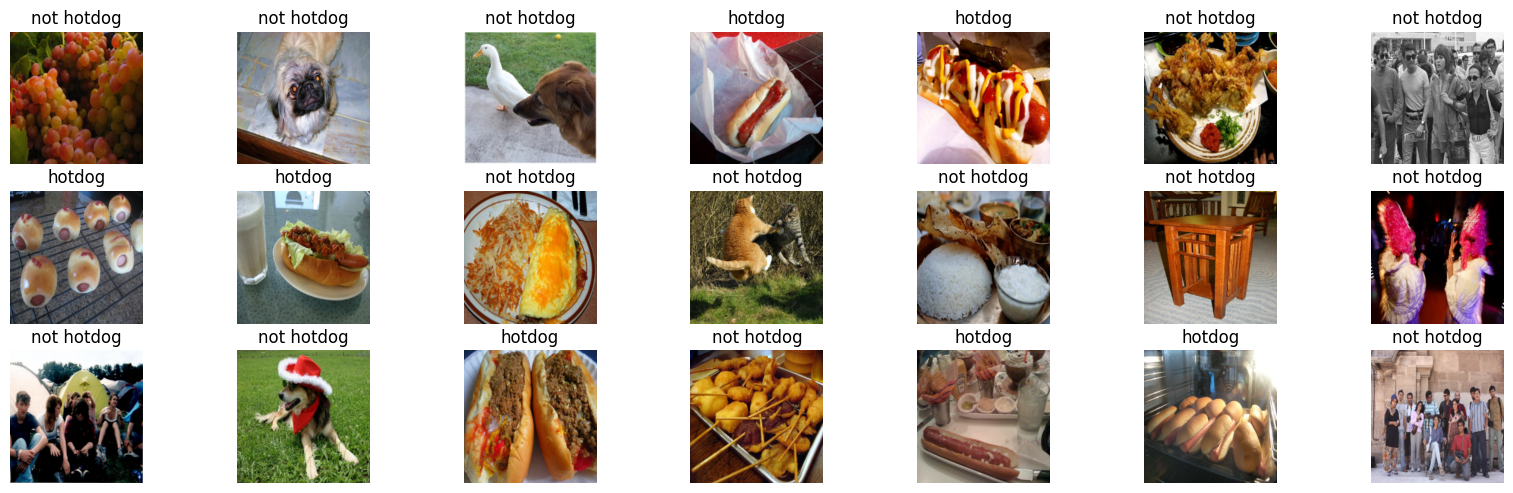

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

Now create a model and train it!


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 16 // 4, 500),
            nn.ReLU(),
            nn.Linear(500, 2)
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fully_connected(x)
        return x

class AdvancedCNN(SimpleCNN):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 32 // 4 // 4, 500),
            nn.ReLU(),
            nn.Linear(500, 2)
        )

class AdvancedBatchNorm(AdvancedCNN):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

class AdvancedDropout(AdvancedCNN):
    def __init__(self):
        super().__init__()
        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 32 // 4 // 4, 500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 2)
        )

class AdvancedFull(SimpleCNN):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 32 // 4 // 4, 500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 2)
        )

In [7]:
models = [SimpleCNN, AdvancedCNN, AdvancedBatchNorm, AdvancedDropout, AdvancedFull]  # store classes, not instances

# Define loss callables and optimizer factories (each factory takes a model instance)
criterions = {
    'ce': nn.CrossEntropyLoss(),
    'nll': lambda output, target: F.nll_loss(F.log_softmax(output, dim=1), target),
}

def make_optimizers():
    return {
        'sgd': lambda m: torch.optim.SGD(m.parameters(), lr=0.1),
        'sgd_mom': lambda m: torch.optim.SGD(m.parameters(), lr=0.01, momentum=0.9),
        'adam': lambda m: torch.optim.Adam(m.parameters(), lr=0.001),
        'adam_decay': lambda m: torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-2),
    }

# Example usage: optimizers = make_optimizers(); optimizer = optimizers['adam'](model_instance)

In [8]:
def train_and_evaluate(model, optimizer, criterion, train_loader, test_loader, num_epochs):
    train_acc, test_acc = [], []
    model.to(device)

    for _ in range(num_epochs):
        # For each epoch
        model.train()
        train_correct = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            # Zero the gradients computed for each weight
            optimizer.zero_grad()
            
            # Forward pass your image through the network
            output = model(data)
            
            # Compute the loss (compute log_softmax over class dimension)
            loss = criterion(output, target)
            
            # Backward pass through the network
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target == predicted).sum().cpu().item()

        # Compute the test accuracy
        model.eval()
        test_correct = 0
        
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target == predicted).sum().item()

        train_acc.append(train_correct/len(trainset))
        test_acc.append(test_correct/len(testset))
        #print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(train=100*train_acc[-1], test=100*test_acc[-1]))
    
    return train_acc, test_acc

In [9]:
num_epochs = 15
model_performance = {}
optimizers = make_optimizers()

# Exact experiments to run (name, ModelClass, optimizer_name, loss_name, use_augmentation)
experiments = [
    ('SimpleCNN_SGD_nll', SimpleCNN, 'sgd', 'nll', False),
    ('AdvancedCNN_SGD_nll', AdvancedCNN, 'sgd', 'nll', False),
    ('AdvancedCNN_SGD_ce', AdvancedCNN, 'sgd', 'ce', False),
    ('AdvancedCNN_Adam', AdvancedCNN, 'adam', 'nll', False),
    ('AdvancedCNN_AdamDecay', AdvancedCNN, 'adam_decay', 'nll', False),
    ('AdvancedBatchNorm_Adam', AdvancedBatchNorm, 'adam', 'nll', False),
    ('AdvancedDropout_Adam', AdvancedDropout, 'adam', 'nll', False),
    ('AdvancedCNN_Adam_Aug', AdvancedCNN, 'adam', 'nll', True),
    ('AdvancedFull_AdamDecay_Aug', AdvancedFull, 'adam_decay', 'nll', True),
]

results = []  # (name, train_curve, test_curve)

for name, model_cls, opt_name, loss_name, use_aug in tqdm(experiments):
    print(f"Running: {name}")
    model = model_cls()
    optimizer = optimizers[opt_name](model)
    criterion = criterions[loss_name]

    train_loader_used = train_loader_aug if use_aug and 'train_loader_aug' in globals() else train_loader

    train_curve, test_curve = train_and_evaluate(model, optimizer, criterion, train_loader_used, test_loader, num_epochs)

    model_performance[name] = {
        'train_curve': train_curve,
        'test_curve': test_curve,
        'final_train': train_curve[-1],
        'final_test': test_curve[-1],
    }
    results.append((name, train_curve, test_curve))

    # free memory
    try:
        del model, optimizer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    except Exception:
        pass

  0%|          | 0/9 [00:00<?, ?it/s]

Running: SimpleCNN_SGD_nll


 11%|█         | 1/9 [02:38<21:07, 158.48s/it]

Running: AdvancedCNN_SGD_nll


 22%|██▏       | 2/9 [04:57<17:10, 147.23s/it]

Running: AdvancedCNN_SGD_ce


 33%|███▎      | 3/9 [07:18<14:25, 144.18s/it]

Running: AdvancedCNN_Adam


 44%|████▍     | 4/9 [09:41<11:59, 143.84s/it]

Running: AdvancedCNN_AdamDecay


 56%|█████▌    | 5/9 [12:04<09:33, 143.28s/it]

Running: AdvancedBatchNorm_Adam


 67%|██████▋   | 6/9 [14:30<07:12, 144.32s/it]

Running: AdvancedDropout_Adam


 78%|███████▊  | 7/9 [16:53<04:48, 144.07s/it]

Running: AdvancedCNN_Adam_Aug


 89%|████████▉ | 8/9 [19:11<02:22, 142.09s/it]

Running: AdvancedFull_AdamDecay_Aug


100%|██████████| 9/9 [21:34<00:00, 143.78s/it]


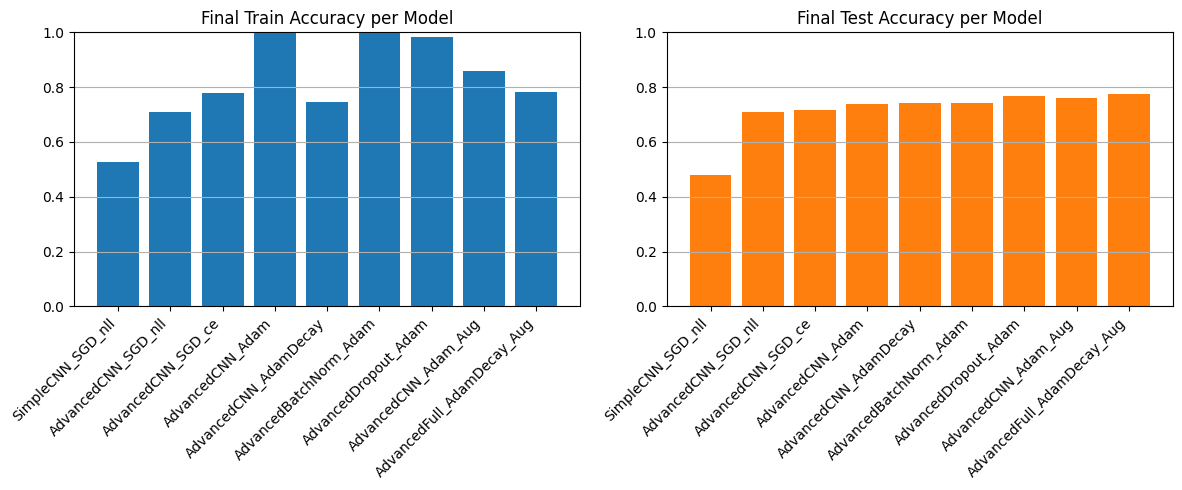

In [10]:
# Plot summary bar charts for final accuracies
names = [r[0] for r in results]
final_train = [model_performance[n]['final_train'] for n in names]
final_test = [model_performance[n]['final_test'] for n in names]

x = np.arange(len(names))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train accuracies
axes[0].bar(x, final_train, color='C0')
axes[0].set_title('Final Train Accuracy per Model')
axes[0].set_xticks(x)
axes[0].set_xticklabels(names, rotation=45, ha='right')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y')

# Test accuracies
axes[1].bar(x, final_test, color='C1')
axes[1].set_title('Final Test Accuracy per Model')
axes[1].set_xticks(x)
axes[1].set_xticklabels(names, rotation=45, ha='right')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y')

plt.tight_layout()
plt.savefig('figures/summary_final_accuracies.png');

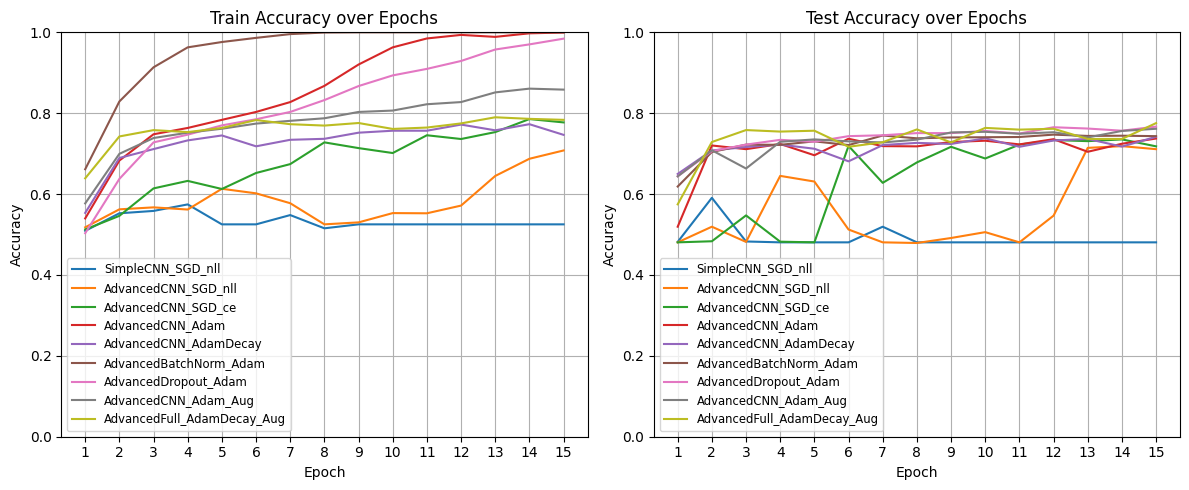

In [11]:
# Epoch-wise accuracy curves for all experiments (train and test)
epochs = np.arange(1, num_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for name, train_curve, test_curve in results:
    axes[0].plot(epochs, train_curve, label=name)
    axes[1].plot(epochs, test_curve, label=name)

axes[0].set_title('Train Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(epochs)
axes[0].set_ylim(0,1)
axes[0].grid()
axes[0].legend(fontsize='small', loc='best')

axes[1].set_title('Test Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(epochs)
axes[1].set_ylim(0,1)
axes[1].grid()
axes[1].legend(fontsize='small', loc='best')

plt.tight_layout()
plt.savefig('figures/epoch_accuracy_curves_all_models.png');

In [12]:
import pickle
with open('models/model_performance.pkl', 'wb') as f:
    pickle.dump(model_performance, f)

In [143]:
# Load model
# model = Net()
# model.load_state_dict(torch.load(f'./models/{model_name}.pth'))

In [ ]:
# Plot train and test accuracy curves
# plt.figure(figsize=(8,5))
# plt.title("Train and Test Accuracy - Adv model with ADAM, weight decay, batch norm, dropout and data augmentation")
# epochs = range(1, num_epochs + 1)
# plt.plot(epochs, train_acc, label="train")
# plt.plot(epochs, test_acc, label="test")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.xlim(1, num_epochs)
# plt.ylim(0, 1)
# plt.xticks(np.arange(1, num_epochs + 1, 1))
# plt.yticks(np.arange(0, 1.05, 0.05))
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.savefig(f'figures/{model_name}_accuracy.jpg')
# plt.show()

In [ ]:
# Save the model
# os.makedirs('./models', exist_ok=True)
# torch.save(model.state_dict(), f'./models/{model_name}.pth')

In [146]:
# model = torch.hub.load('pytrorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Resize images and preprocess before